In [31]:
import seaborn as sns
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import Orange
import numpy as np

# Load data

In [32]:
logfile_name = 'rerun_results.txt'
auroc_columns = ['Drug', 'Dataset', 'Auroc', 'Method']
auprc_columns = ['Drug', 'Dataset', 'Auprc', 'Method']
auroc_table_columns = ['Drug', 'Dataset', 'Auroc', 'Method']
auprc_table_columns = ['Drug', 'Dataset', 'Auprc', 'Method']

auroc_result_dataframe = pd.DataFrame(columns=auroc_columns)
auprc_result_dataframe = pd.DataFrame(columns=auprc_columns)
result_path = Path('..', 'results', 'bayesian_optimisation')

drug_paths =  [x for x in result_path.iterdir()]
for drug_path in drug_paths:
    drug = drug_path.stem
    if drug in ('EGFR', 'ensemble'):
        continue
    method_folder = [path.stem for path in drug_path.iterdir()]
    for logfile_folder in method_folder:
        method = logfile_folder
        log_path = drug_path / logfile_folder / logfile_name
        test_aupcr = []
        extern_auprc = []
        if log_path.is_file():
            with open(log_path, 'r') as log_file:
                for line in log_file:
                    if 'test auroc list' in line:
                        numbers = line.partition('[')[2].partition(']')[0]
                        test_auroc = [float(number) for number in numbers.split(',')]
                    if 'extern auroc list' in line:
                        numbers = line.partition('[')[2].partition(']')[0]
                        extern_auroc = [float(number) for number in numbers.split(',')]
                    if 'test auprc list' in line:
                        numbers = line.partition('[')[2].partition(']')[0]
                        test_aupcr = [float(number) for number in numbers.split(',')]
                    if 'extern auprc list' in line:
                        numbers = line.partition('[')[2].partition(']')[0]
                        extern_auprc = [float(number) for number in numbers.split(',')]
                    if 'skill predictor' in line:
                        no_skill_auprc = float(line.split(':')[-1])
                    if 'test auroc mean' in line:
                        test_auroc_mean = float(line.split(':')[-1])
                    if 'test auroc std' in line:
                        test_auroc_std = float(line.split(':')[-1])
                    if 'test_auprc mean' in line:
                        test_auprc_mean = float(line.split(':')[-1])
                    if 'test_auprc std' in line:
                        test_auprc_std = float(line.split(':')[-1])
                    
                        
                for auroc in test_auroc:
                    auroc_result_dataframe = auroc_result_dataframe.append(
                        pd.DataFrame([[drug, f'Test', auroc, method]], columns=auroc_columns))
                for auroc in extern_auroc:
                    auroc_result_dataframe = auroc_result_dataframe.append(
                        pd.DataFrame([[drug, f'Extern', auroc, method]], columns=auroc_columns))
                for auprc in test_aupcr:
                    auprc_result_dataframe = auprc_result_dataframe.append(
                        pd.DataFrame([[drug, f'Test', auprc, method]], columns=auprc_columns))
                for auprc in extern_auprc:
                    auprc_result_dataframe = auprc_result_dataframe.append(
                        pd.DataFrame([[drug, f'Extern', auprc, method]], columns=auprc_columns))

## Beautify strings

In [33]:
auroc_result_dataframe = auroc_result_dataframe.replace('all_drugs_with_error_bar', 'Bo-Holi-MOLI')
auroc_result_dataframe = auroc_result_dataframe.replace('holi_only__more_sobol', 'Random-Holi-MOLI')
auroc_result_dataframe = auroc_result_dataframe.replace('moli', 'MOLI')
auroc_result_dataframe = auroc_result_dataframe.replace('holi_moli_saasbo_50_sobol', 'SAASBO')
auroc_result_dataframe = auroc_result_dataframe.replace('holi_moli_gp_30_sobol', 'Holi-Moli-more-Sobol')
auroc_result_dataframe = auroc_result_dataframe.replace('Gemcitabine_pdx', 'Gemcitabine with PDX')
auroc_result_dataframe = auroc_result_dataframe.replace('Gemcitabine_tcga', 'Gemcitabine with TCGA')

auprc_result_dataframe = auprc_result_dataframe.replace('all_drugs_with_error_bar', 'Bo-Holi-MOLI')
auprc_result_dataframe = auprc_result_dataframe.replace('holi_only__more_sobol', 'Random-Holi-MOLI')
auprc_result_dataframe = auprc_result_dataframe.replace('moli', 'MOLI')
auprc_result_dataframe = auprc_result_dataframe.replace('holi_moli_saasbo_50_sobol', 'SAASBO')
auprc_result_dataframe = auprc_result_dataframe.replace('holi_moli_gp_30_sobol', 'Holi-Moli-more-Sobol')
auprc_result_dataframe = auprc_result_dataframe.replace('Gemcitabine_pdx', 'Gemcitabine with PDX')
auprc_result_dataframe = auprc_result_dataframe.replace('Gemcitabine_tcga', 'Gemcitabine with TCGA')

## Calculate critical test difference

In [34]:
mean_results_df = auroc_result_dataframe.groupby(['Method', 'Drug', 'Dataset']).mean()


test_mean_results_df = mean_results_df.loc[:, :, 'Test']
extern_mean_results_df = mean_results_df.loc[:, :, 'Extern']

auroc_ranking_extern = extern_mean_results_df.groupby('Drug').rank(axis=0, ascending=False)\
.groupby(['Method']).mean()
auroc_ranking_test = test_mean_results_df.groupby('Drug').rank(axis=0, ascending=False)\
.groupby(['Method']).mean()

number_of_datasets  = 7

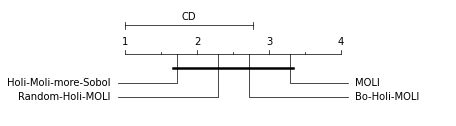

In [35]:
critical_difference = Orange.evaluation.compute_CD(auroc_ranking_test, 
                                                   number_of_datasets, alpha='0.05')
Orange.evaluation.graph_ranks(auroc_ranking_test.values.squeeze(), auroc_ranking_test.index,
                              cd=critical_difference, width=6, textspace=1.5)
plt.savefig('critical_difference_test_auroc.pdf')

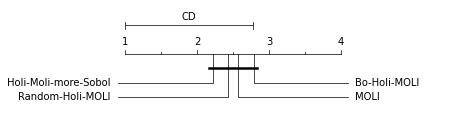

In [36]:
critical_difference = Orange.evaluation.compute_CD(auroc_ranking_extern, number_of_dataset, alpha='0.05')
Orange.evaluation.graph_ranks(auroc_ranking_extern.values.squeeze(), auroc_ranking_extern.index, 
                              cd=critical_difference, width=6, textspace=1.5)
plt.savefig('critical_difference_extern_auroc.pdf')

## Calculate critical extern difference

In [37]:
mean_results_df = auprc_result_dataframe.groupby(['Method', 'Drug', 'Dataset']).mean()
test_mean_results_df = mean_results_df.loc[:, :, 'Test']
extern_mean_results_df = mean_results_df.loc[:, :, 'Extern']

auprc_ranking_extern = extern_mean_results_df.groupby('Drug').rank(axis=0, ascending=False)\
.groupby(['Method']).mean()
auprc_ranking_test = test_mean_results_df.groupby('Drug').rank(axis=0, ascending=False)\
.groupby(['Method']).mean()

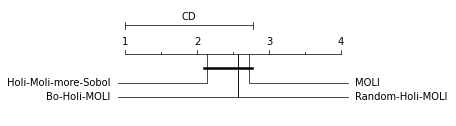

In [38]:
critical_difference = Orange.evaluation.compute_CD(auprc_ranking_test, 
                                                   number_of_dataset, alpha='0.05')
Orange.evaluation.graph_ranks(auprc_ranking_test.values.squeeze(), auprc_ranking_test.index,
                              cd=critical_difference, width=6, textspace=1.5)
plt.savefig('critical_difference_test_auprc.pdf')

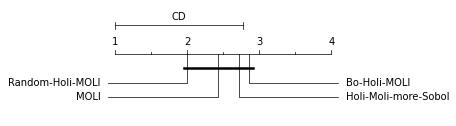

In [39]:
critical_difference = Orange.evaluation.compute_CD(auprc_ranking_extern, number_of_dataset, alpha='0.05')
Orange.evaluation.graph_ranks(auprc_ranking_extern.values.squeeze(), 
                              auprc_ranking_extern.index, cd=critical_difference, \
                              width=6, textspace=1.5)
plt.savefig('critical_difference_extern_auprc.pdf')